In [2]:
import numpy as np
import pandas as pd

In [48]:
with open('letter.names', 'r') as f:
    col_names = f.read()

col_names = col_names.split('\n')
col_names.append('trash') # for garbage \n2 delimiters in letter.names

In [94]:
data = pd.read_csv('letter.data', sep="\t", header=None, names=col_names).drop(['id', 'next_id', 'word_id', 'position', 'fold', 'trash'], axis=1) # k fold cross validation not needed

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline

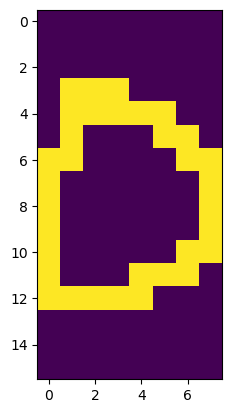

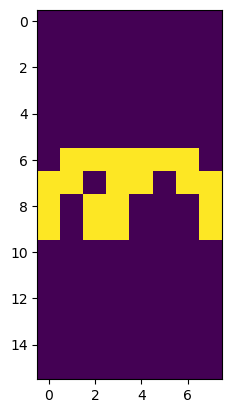

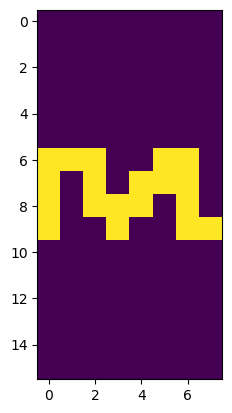

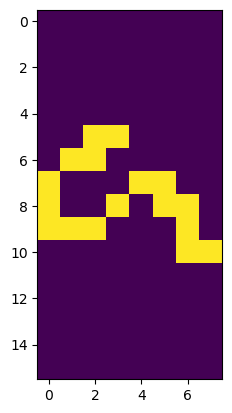

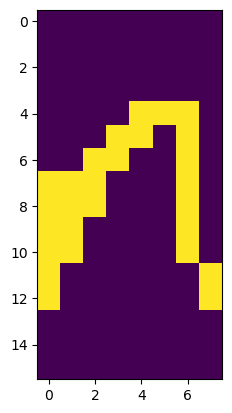

In [96]:
num_examples = 5
examples = np.array(data[:num_examples])[:, 1:].reshape(num_examples, 16, 8).astype('float32')
for example in examples:
    plt.imshow(example)
    plt.show()

In [167]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [168]:
class ImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        """ choose to process data file within class initialization """
        data = pd.read_csv(img_dir, sep="\t", header=None, names=col_names).drop(['id', 'next_id', 'word_id', 'position', 'fold', 'trash'], axis=1) # k fold cross validation not needed
        self.img_labels = data['letter']
        self.img_data = data.drop('letter', axis=1) # keeps it as (n x 128 matrix)
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        """ data stored in pd dataframe, return image as 16x8 reshaped tensor"""
        image = torch.tensor(self.img_data.iloc[idx].to_numpy()).view(16, 8)
        label = self.img_labels.iloc[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
    

In [169]:
batch_size = 64

data = ImageDataset('letter.data')

train_indices, val_indices, test_indices = torch.utils.data.random_split(range(len(data)), [0.8, 0.1, 0.1])

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, 
                                                sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,
                                                sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,
                                                sampler=test_sampler)


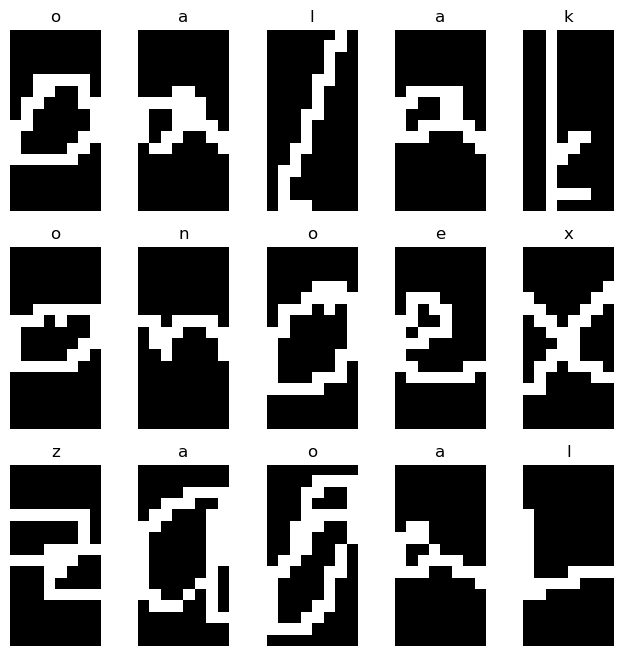

In [170]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 5, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(data), size=(1,)).item()
    img, label = data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [171]:
import torch.nn as nn
import torch.nn.functional as F

device = 'mps' if torch.mps.is_available() else 'cpu'

class CNN(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 1, kernel_size),
            nn.Conv2d(1, 1, kernel_size),
        )
    
    def forward(self, idx, targets=None):
        out = self.layers(idx)
        if targets == None:
            loss = None
        else:
            loss = F.cross_entropy(out, targets)
        
        return out, loss

In [172]:
model = CNN(3)
model = model.to(device)

learning_rate = 1e-3
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [ ]:
# @torch.no_grad()
# def estimate_loss():
#     out = {}
#     model.eval()
#     for split in ['train', 'val']:
#         losses = torch.zeros(100)
#         for k in range(100):
#             X, Y = get_batch(split)
#             logits, loss = model(X, Y)
#             losses[k] = loss.item()
#         out[split] = losses.mean()
#     model.train()
#     return out

In [173]:
for iter in range(1000):

    # every once in a while evaluate the loss on train and val sets
    # if iter % 100 == 0:
    #     losses = estimate_loss()
    #     print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = next(iter(test_loader))

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

TypeError: 'int' object is not callable